I used Men-Women Classification Datset From Kaggle
Link : https://www.kaggle.com/datasets/saadpd/menwomen-classification
this one used from transfer learning + Data Augmentation

In [1]:
import os , shutil, pathlib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'   # hides INFO/WARNING logs from TF C++
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

In [2]:
# dataset_dir = r"/home/hamid/ML/Datasets/Men-Women/"
# num_train = len(os.listdir(dataset_dir + r"/traindata/traindata/men/"))

In [3]:
original_dir = pathlib.Path(r"/home/hamid/ML/Datasets/Men-Women/traindata/traindata/")
new_base_dir = pathlib.Path(r"/home/hamid/ML/Datasets/Men-Women-small")

In [4]:
def make_subset(subset_name , start_index, end_index):
    if (new_base_dir / subset_name).exists():
        shutil.rmtree(new_base_dir / subset_name)
    for category in ("men" , "women"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg"
                 for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src = original_dir / category / fname , dst = dir / fname)
make_subset("train" , start_index = 0, end_index = 1000)
make_subset("validation" , start_index = 1000, end_index = 1200)
make_subset("test" , start_index = 1200, end_index = 1400)

In [5]:
train_dataset = image_dataset_from_directory(
    r"/home/hamid/ML/Datasets/Men-Women-small/train",
    image_size = (180 , 180),
    batch_size = 32 ,
    label_mode = "binary"
)

validation_dataset = image_dataset_from_directory(
    r"/home/hamid/ML/Datasets/Men-Women-small/validation",
    image_size = (180 , 180),
    batch_size = 32 ,
    label_mode = "binary"
)

test_dataset = image_dataset_from_directory(
    r"/home/hamid/ML/Datasets/Men-Women-small/test",
    image_size = (180 , 180),
    batch_size = 32 ,
    label_mode = "binary"
)

Found 2000 files belonging to 2 classes.


I0000 00:00:1765038079.122003  242510 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1242 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [7]:
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet" ,
    include_top = False , 
    input_shape = (180 , 180 , 3)
)

In [8]:
conv_base.trainable = False # I use it at first run

In [9]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        257 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset ,
    callbacks=callbacks,
)

Epoch 1/50


W0000 00:00:1765038081.803666  242583 gpu_utils.cc:68] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.7420 - loss: 1.4498 - val_accuracy: 0.8000 - val_loss: 1.1234
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8000 - loss: 1.1589 - val_accuracy: 0.8325 - val_loss: 1.3152
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.8235 - loss: 0.8744 - val_accuracy: 0.8225 - val_loss: 1.0816
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.8315 - loss: 0.6935 - val_accuracy: 0.8300 - val_loss: 0.9485
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.8370 - loss: 0.7350 - val_accuracy: 0.8350 - val_loss: 0.8181
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.8370 - loss: 0.7021 - val_accuracy: 0.8300 - val_loss: 0.7448
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.8565 - loss: 0.6064 - val_accuracy: 0.8400 - val_loss: 0.7041
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.8270 - loss: 0.6644 - val_accuracy: 0.8325 - val_

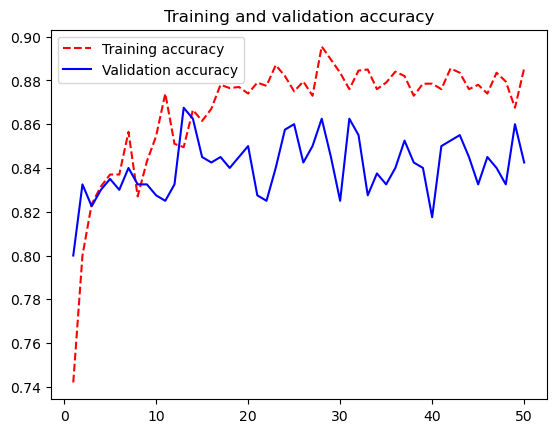

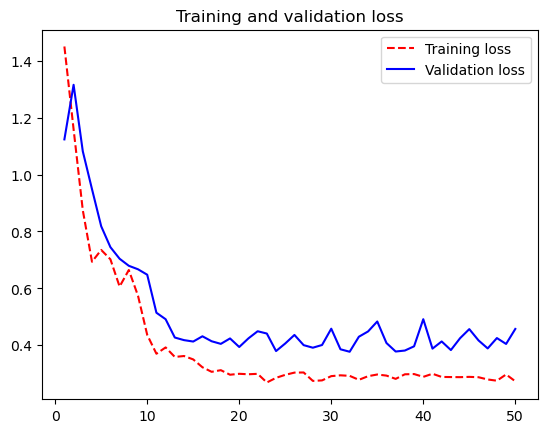

In [11]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "r--", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [13]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9100 - loss: 0.2740
Test accuracy: 0.910


In [16]:
conv_base.trianable = True
for layer in conv_base.layers[:-4]:
    layer.trianable = False

In [18]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.8915 - loss: 0.2553 - val_accuracy: 0.8550 - val_loss: 0.4411
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.8900 - loss: 0.2685 - val_accuracy: 0.8525 - val_loss: 0.4379
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.8890 - loss: 0.2573 - val_accuracy: 0.8525 - val_loss: 0.4363
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.8940 - loss: 0.2688 - val_accuracy: 0.8525 - val_loss: 0.4363
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.8960 - loss: 0.2562 - val_accuracy: 0.8500 - val_loss: 0.4345
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.8930 - loss: 0.2654 - val_accuracy: 0.8525 - val_loss: 0.4356
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.8995 - loss: 0.2546 - val_accuracy: 0.8500 - val_loss: 0.4359
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.8935 - loss: 0.2679 - val_accuracy: 0.8

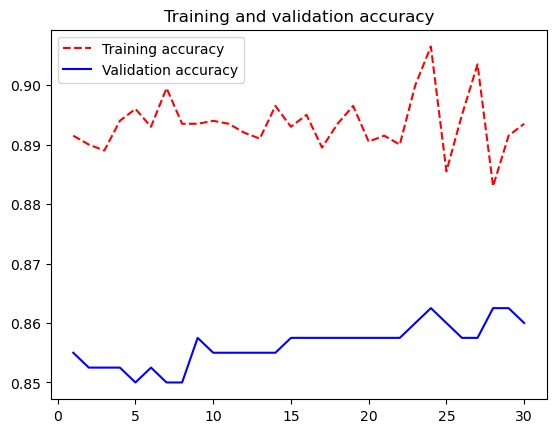

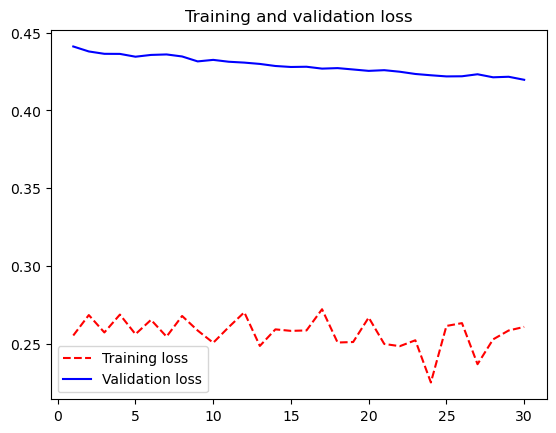

In [20]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "r--", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [48]:
#this is for Cleaning GPU Memory
tf.keras.backend.clear_session()
#test data
test_model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9075 - loss: 0.2731
Test accuracy: 0.908


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


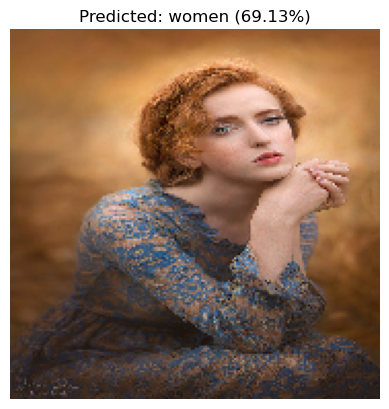

Raw Score: 0.6913
Final Prediction: women


In [49]:
# ---- CONFIG ----
img_path = "/home/hamid/Downloads/Picture/test10.jpg"
img_height = 180   
img_width = 180


# ---- LOAD IMAGE ----
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) 



# ---- PREDICT ----
predictions = model.predict(img_array)
score = predictions[0][0]  

if score >= 0.5:
    predicted_label = "women"
    confidence = score * 100
else:
    predicted_label = "men"
    confidence = (1 - score) * 100

plt.imshow(img)
plt.title(f"Predicted: {predicted_label} ({confidence:.2f}%)")
plt.axis("off")
plt.show()

print(f"Raw Score: {score:.4f}")
print(f"Final Prediction: {predicted_label}")